This notebook build the dataset with speaker attributes, do some checks, and provide a code cell for merging data from different years.

# Preparing the environment

In [1]:
import bz2
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import tldextract

data_dir = "../data/"
raw_data_dir = "../raw_data/"

# Additional datasets

## Speaker attributes

Let's first take a look at how the speaker_attributes dataset, as given for this project, looks like. The file `schema_speaker_attributes.txt` lists the provided columns.

For example, if we want to see the names, aliases and genders of the speakers, we can do the following:

In [2]:
speaker_attributes = ['gender', 'nationality']
speaker_attrs_df = pd.read_parquet(raw_data_dir+"speaker_attributes.parquet", columns=['id']+speaker_attributes)
speaker_attrs_df.head()

,id,gender,nationality
0,Q23,[Q6581097],"[Q161885, Q30]"
1,Q42,[Q6581097],[Q145]
2,Q1868,[Q6581097],[Q31]
3,Q207,[Q6581097],[Q30]
4,Q297,[Q6581097],[Q29]


The wikidata labels descriptions allows us to convert the qids to a human readable format.

In [3]:
pd.read_csv(raw_data_dir+"wikidata_labels_descriptions_quotebank.csv.bz2", compression='bz2').head()

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


## Speaker attributes filtering

To manipulate more easily the speaker attributes dataset, we'll filter it with speaker qids we have in our filtered quotebank dataset.

In [4]:
df = pd.read_json(data_dir+"filtered2020.json.bz2", lines=True, compression='bz2')
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-03-18-001607,a special lifelong animal advocate.,None,[],2020-03-18 19:42:36,1,"[[None, 0.8046], [Betty White, 0.085], [Winona...",[https://www.nbc15.com/content/news/Henry-Vila...,E
1,2020-02-19-002557,Academic environments are not the best places ...,Lewis Von Thaer,[Q22096796],2020-02-19 23:42:44,2,"[[Lewis Von Thaer, 0.5349], [None, 0.2953], [C...",[https://www.thelantern.com/2020/02/student-co...,E
2,2020-04-03-002052,After talking with Chris about his background ...,Brad Smith,"[Q15477554, Q16218831, Q23664265, Q24084114, Q...",2020-04-03 15:16:31,1,"[[Brad Smith, 0.7482], [None, 0.2469], [Chris ...",[http://www.hmenews.com/article/brief-package-...,E
3,2020-03-29-001856,Animal caretaker Ambre Cook talks about the re...,None,[],2020-03-29 14:05:00,2,"[[None, 0.6996], [Sarah Silverman, 0.3004]]",[http://newsok.com/article/5658897/interviews-...,E
4,2020-02-02-004706,Because this hardworking talented human of min...,Ashwiny Iyer Tiwari,[Q28012317],2020-02-02 05:14:15,2,"[[Ashwiny Iyer Tiwari, 0.4128], [None, 0.3853]...",[https://www.hindustantimes.com/bollywood/kang...,E


The following cells retrieve the attributes of the qids present in our filtered dataset.

In [5]:
# Get the list of qids in our filtered quotebank dataset
speaker_qids = df['qids'].explode().dropna().drop_duplicates()
print(f"{len(speaker_qids)} speaker qids found.")

52583 speaker qids found.


In [6]:
attrs_pq = pq.read_table(
    raw_data_dir+"speaker_attributes.parquet",
    filters=[
        ('id', 'in', speaker_qids)
    ]
)
attrs_df = attrs_pq.to_pandas()
print(f"Retrieved attributes of {len(attrs_df)} speaker qids.")
attrs_df.head()

Retrieved attributes of 51951 speaker qids.


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
1,"[Neil Percival Young, Shakey, Godfather of Gru...",[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
2,"[Mary Louise Streep, Meryl Louise Streep, Stre...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1388232380,None,None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",[Q29552],None,Q873,Meryl Streep,None,item,[Q7066]
3,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089]
4,"[Ban Kimoon, Ban Ki Moon]",[+1944-06-13T00:00:00Z],[Q884],[Q6581097],1384825460,[Q484464],None,"[Q82955, Q193391]",[Q327591],None,Q1253,Ban Ki-moon,None,item,"[Q9581, Q748]"


The next cell create the filtered_speaker_attributes dataset file, for latter usage.

In [7]:
attrs_df.to_json(data_dir+"filtered_speaker_attributes.json.bz2", compression="bz2")

# Building the extended filtered dataset

We have already filtered the quotebank dataset, and we now want to extend it with our additional datasets. We'll also build the file for latter usage.

In [37]:
YEAR = 2019
IN_FILE = f"quotebank_filtered_{YEAR}.json.bz2"
OUT_FILE  = f"quotebank_filtered_{YEAR}_attrs.json.bz2"

In [38]:
df = pd.read_json(data_dir+IN_FILE, lines=True, compression='bz2')
attrs_df = pd.read_json(data_dir+"filtered_speaker_attributes.json.bz2", compression='bz2')

print(f"Filtered quotebank dataset: {len(df)} lines")
print(f"Filtered speaker attributes dataset: {len(attrs_df)} lines")

Filtered quotebank dataset: 15204 lines
Filtered speaker attributes dataset: 51951 lines


We select the attributes we want for the speakers.

In [39]:
attrs_columns = ['gender', 'nationality', 'date_of_birth', 'ethnic_group',
    'occupation', 'party', 'academic_degree']
attrs_df = attrs_df[attrs_columns + ['id']]
attrs_df.head()

,gender,nationality,date_of_birth,ethnic_group,occupation,party,academic_degree,id
0,[Q6581097],[Q30],[+1946-07-06T00:00:00Z],None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207
1,[Q6581097],"[Q16, Q30]",[+1945-11-12T00:00:00Z],None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633
2,[Q6581072],[Q30],[+1949-06-22T00:00:00Z],None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",[Q29552],None,Q873
3,[Q6581097],[Q668],[+1950-09-17T00:00:00Z],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058
4,[Q6581097],[Q884],[+1944-06-13T00:00:00Z],[Q484464],"[Q82955, Q193391]",[Q327591],None,Q1253


Before merging, we want to make the qids human readable.

In [40]:
labels_df = pd.read_csv(raw_data_dir+"wikidata_labels_descriptions_quotebank.csv.bz2", compression='bz2', index_col='QID')
labels_df.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [41]:
cols = ['gender', 'nationality', 'ethnic_group', 'occupation', 'party', 'academic_degree']

def compute_el(x):
    if x == None:
        return
    return list(map(lambda el: labels_df.loc[el, 'Label'], x))

for col in cols:
    attrs_df[col] = attrs_df[col].apply(compute_el)

And add it to our main dataframe. For now, we select a speaker qid only if there is exactly one match (i.e. `len(qids) == 1`).

In [42]:
df['speaker_qid'] = df.qids.apply(lambda qids: qids[0] if len(qids) == 1 else None)
df = df.merge(attrs_df, how="left", left_on="speaker_qid", right_on="id").drop("id", axis=1)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_qid,gender,nationality,date_of_birth,ethnic_group,occupation,party,academic_degree
0,2019-02-04-002400,A vegan dinner party... is that even a thing?,Jason Bateman,[Q284636],2019-02-04 09:37:37,1,"[[Jason Bateman, 0.8851], [None, 0.1149]]",[http://independent.co.uk/life-style/hyundai-s...,E,Q284636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-09-05-055021,"It was the usual things-doesn't play the game,...",Charles Teo,[Q5082886],2019-09-05 09:45:00,1,"[[Charles Teo, 0.4713], [None, 0.4559], [Ashra...",[http://www.brisbanetimes.com.au/national/from...,E,Q5082886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-10-09-058995,I've grown up in a European family that doesn'...,None,[],2019-10-09 18:35:22,5,"[[None, 0.8079], [Mark McEwan, 0.1921]]",[https://calgaryherald.com/life/food/from-butt...,E,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-09-04-078532,So there's the future. No more beef wellington...,Piers Morgan,[Q557758],2019-09-04 13:31:48,1,"[[Piers Morgan, 0.9351], [None, 0.0395], [Susa...",[http://www.entertainmentdaily.co.uk/daytime-t...,E,Q557758,[male],[United Kingdom],[+1965-03-30T00:00:00Z],None,"[journalist, television presenter, diarist]",None,None
4,2019-09-24-027988,I also just wan na say that I'm vegetarian. I'...,None,[],2019-09-24 15:34:11,1,"[[None, 0.4676], [Will Smith, 0.3501], [Jaden ...",[https://perezhilton.com/jaden-smith-vegetaria...,E,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Other way

# filename = "quotes-2020.json.bz2"
# with bz2.open(data_dir+filename, 'rb') as s_file:
#     with bz2.open(preprocessed_data_dir+filename, 'wb') as d_file:
#         for instance in s_file:
#             instance = json.loads(instance)
#             qids = instance['qids']
#             speaker_qid = qids[0] if len(qids) else None
#             new_instance = dict(
#                 quoteID=instance['quoteID'],
#                 quotation=instance['quotation'],
#                 speaker=instance['speaker'],
#                 speaker_qid=speaker_qid,
#             )
#             d_file.write((json.dumps(new_instance)+"\n").encode('utf-8'))

## Domain

In [44]:
def get_domain(url):
    r = tldextract.extract(url)
    return f"{r.domain}.{r.suffix}"

df['domains'] = df['urls'].apply(lambda r: list(map(get_domain, r)))

## Save the dataset

The following cell save the dataset into a compressed json file for latter usage.

In [45]:
df.to_json(data_dir+OUT_FILE, compression="bz2")

# Analyzing the quotebank raw dataset

## Multiple speaker qids issue

Quotebank provides a list of possible qids matching the speaker (it cannot guess which wikipedia page is actually the right one). Before taking a decision on how to solve the problem, let's take a look at the distribution.

In [16]:
qid_counts = pd.Series(dtype=int)
with pd.read_json(raw_data_dir+"quotes-2020.json.bz2", lines=True, compression='bz2', chunksize=100000) as df_reader:
    for chunk in df_reader:
        qid_counts = qid_counts.add(chunk['qids'].str.len(), fill_value=0)

In [17]:
print(f"Number of rows: {len(qid_counts)}")
qid_counts.describe()

Number of rows: 5244449


count    5.244449e+06
mean     1.443974e+00
std      4.083868e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.510000e+02
dtype: float64

Before plotting the distribution, let's remove the outliers:

In [18]:
thresh = 15
qid_counts_clean = qid_counts[qid_counts < thresh] / len(qid_counts)
p_removed = 1 - len(qid_counts_clean) / len(qid_counts)
print(f"Removed {p_removed*100:.2f}% of rows.")

Removed 1.14% of rows.


[]

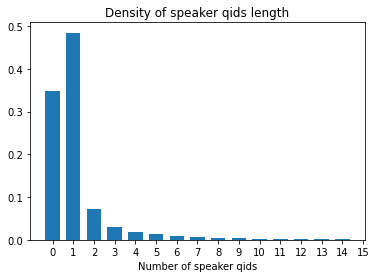

In [19]:
qid_counts_clean = qid_counts[qid_counts < thresh].astype(int)
bins = np.arange(0, qid_counts_clean.max() + 1.5) - 0.5

plt.hist(qid_counts_clean, bins, density=True, rwidth=0.7)
plt.xticks(bins + 0.5)
plt.title("Density of speaker qids length")
plt.xlabel("Number of speaker qids")
plt.plot()

We can see that half of the quote will have a single speaker qid.

# Merging processed data from different years

Applying our pipeline year by year allows us to compute it quicker, in case we modify it and test it. One year analysis is also simpler when trying different analysis, simply because it computes faster, giving us a glimpse of the result while also improving our algorithms. Then, when we are confident about our code, we can take time to compute it to the whole dataset and enjoy the results:

In [54]:
filename = data_dir + 'quotebank_filtered_{}_attrs.json.bz2'
years = range(2015, 2021)

merged_df = pd.concat([
    pd.read_json(filename.format(year), compression='bz2')\
    for year in years
], ignore_index=True)

merged_df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_qid,gender,nationality,date_of_birth,ethnic_group,occupation,party,academic_degree,domains
0,2015-10-05-010038,At Neath Food Festival with a vegetarian platt...,Bethan Jenkins,[Q4897688],2015-10-05 05:00:00,1,"[[Bethan Jenkins, 0.8565], [None, 0.1435]]",[http://www.southwales-eveningpost.co.uk/Town-...,E,Q4897688,None,None,None,None,None,None,None,[southwales-eveningpost.co.uk]
1,2015-11-28-006688,"But if I had to choose my favourite recipe, it...",Trish Deseine,[Q7843986],2015-11-28 00:00:00,1,"[[Trish Deseine, 0.7664], [None, 0.1125], [Kei...",[http://www.irishexaminer.com/lifestyle/featur...,E,Q7843986,None,None,None,None,None,None,None,[irishexaminer.com]
2,2015-11-10-015422,"Children are learning about responsibility, te...",David Price,"[Q1176177, Q16063598, Q20804677, Q20973688, Q3...",2015-11-10 19:30:41,1,"[[David Price, 0.7849], [None, 0.2151]]",[http://news.ifas.ufl.edu/2015/11/ufifas-bok-t...,E,None,None,None,None,None,None,None,None,[ufl.edu]
3,2015-01-16-054273,Once we have added all the vegetables and stoc...,None,[],2015-01-16 11:40:11,4,"[[None, 0.6778], [Catherine O'Neill, 0.3222]]",[http://www.bromsgrovestandard.co.uk/2015/01/1...,E,None,None,None,None,None,None,None,None,"[bromsgrovestandard.co.uk, bromsgrovestandard...."
4,2015-02-20-089622,vegans in a steakhouse.,Jim Gaffigan,[Q2093638],2015-02-20 00:05:44,1,"[[Jim Gaffigan, 0.7894], [None, 0.2106]]",[http://unfspinnaker.com/expect-jim-gaffigans-...,E,Q2093638,[male],[United States of America],[+1966-07-07T00:00:00Z],None,"[screenwriter, film producer, television actor...",None,None,[unfspinnaker.com]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66579,2020-02-20-028821,I suppose because of my size and what I do for...,None,[],2020-02-20 19:00:00,2,"[[None, 0.7036], [Anthony Mullally, 0.2063], [...",[https://www.stuff.co.nz/sport/league/11967886...,E,None,None,None,None,None,None,None,None,"[stuff.co.nz, nzcity.co.nz]"
66580,2020-01-23-046052,In the early 2000s the City of Cedar Rapids wa...,Jason Andrews,"[Q22704361, Q55523316]",2020-01-23 13:00:05,1,"[[Jason Andrews, 0.8019], [None, 0.1981]]",[https://adventure.howstuffworks.com/outdoor-a...,E,None,None,None,None,None,None,None,None,[howstuffworks.com]
66581,2020-03-26-047830,People have mostly stayed in the last couple o...,Arvind Kejriwal,[Q59155],2020-03-26 09:10:20,2,"[[Arvind Kejriwal, 0.6215], [None, 0.3786]]",[https://www.newindianexpress.com/cities/delhi...,E,Q59155,[male],[India],[+1968-08-16T00:00:00Z],None,"[politician, bureaucrat]",[Aam Aadmi Party],None,"[newindianexpress.com, newkerala.com]"
66582,2020-04-04-035826,We have been seeing reports of farmers dumping...,Narayana Gowda,[Q6965507],2020-04-04 00:38:36,1,"[[Narayana Gowda, 0.8262], [None, 0.1738]]",[http://www.bangaloremirror.com/bangalore/othe...,E,Q6965507,[male],[India],[+1966-06-10T00:00:00Z],None,"[politician, activist]",[Janata Dal (Secular)],None,[bangaloremirror.com]


In [55]:
merged_df.to_json(data_dir+'quotebank_attr_2015-2020.json.bz2', compression="bz2")